In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## read the datasets in Nature Comm Paper: kong et al. https://www.nature.com/articles/s41467-022-31535-6
# https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-022-31535-6/MediaObjects/41467_2022_31535_MOESM1_ESM.pdf

dfd = pd.read_csv('../dataset_stat_nc.csv')
dfdt = dfd.groupby(['dataset','response']).size().to_frame(name='size').reset_index()
liu = dfd[dfd.dataset=='Liu'].set_index('sampleID')
pd.pivot_table(dfdt, 'size', 'response', 'dataset').T

response,nonresponder,responder
dataset,,
Auslander,34,3
Gide,42,49
IMvigor210,230,68
Kim,33,12
Liu,72,47
Prat,16,9
Riaz,39,10


In [3]:
patient = pd.read_csv('./raw/clinical_info.csv', sep=',', index_col=0)
len(patient)

144

# get label

In [4]:
patient.BR.value_counts() 
#Patients achieving CR or PR as BOR were grouped as responders, 
#whereas patients showing PD as the best response were referred to as progressors
#Becare to the tissue,should be melanomas instead of normal.
resmap = {'PD':'nonresponder', 'CR':'responder', 'PR':'responder', 'BOR':'responder'}

In [5]:
label = patient.BR.map(resmap).to_frame(name = 'label.liu').join(liu.response.to_frame(name = 'label.kong'))
label.head(10)

,label.liu,label.kong
Patient1,nonresponder,nonresponder
Patient10,responder,responder
Patient100,responder,responder
Patient102,NaN,NaN
Patient104,responder,NaN
Patient105,NaN,NaN
Patient106,responder,responder
Patient107,responder,responder
Patient108,nonresponder,nonresponder
Patient11,nonresponder,nonresponder


In [6]:
label['label.liu'].value_counts()

nonresponder    65
responder       55
Name: label.liu, dtype: int64

In [7]:
label['label.kong'].value_counts()

nonresponder    72
responder       47
Name: label.kong, dtype: int64

# get TMB


* 1) TMB by [Wang](https://www.nature.com/articles/s41467-022-31535-6#ref-CR63)： TMBpatient=𝑇patient2.0+𝑁𝑇patient×1.，where Tpatient is total number of truncating mutations and NTpatient is the total number of non-truncating mutations. For truncating mutations, we considered nonsense mutations, frame-shift deletion or insertion and splice-site mutations. For non-truncating mutations, we used missense mutations, in-frame deletion or insertion, and nonstop mutations.
* 2) TMB by [Dan](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7710563/)： 

    Step1: Calculate Total number N of non-synonymous, somatic mutations with eligible classification (list below) in MAF
    * "Frame_Shift_Del"
    * "Frame_Shift_Ins" 
	* "In_Frame_Del" 
	* "In_Frame_Ins" 
	* "Missense_Mutation" 
	* "Nonsense_Mutation" 
	* "Splice_Site"
	* "Nonstop_Mutation" 
	* "Splice_Region", 
  
  Step 2: Determine the size L of genome coding area of DNA in megabase(Mb), For WES/WGS: L = 30
  
### 原始paper直接采用第二种 Nonsynonymous非同义突变的个数，我们使用mutaion文件复现

In [8]:
VC_NONSYNONYMOUS_LIST = ['Frame_Shift_Del',
                         'Frame_Shift_Ins',
                         'In_Frame_Del',
                         'In_Frame_Ins',
                         'Missense_Mutation',
                         'Nonsense_Mutation',
                         'Splice_Site',
                         'Nonstop_Mutation',
                         'Splice_Region']

truncate_mut_LIST = ['Nonsense_Mutation', 'Frame_Shift_Ins','Frame_Shift_Del','Splice_Site']
nontruncate_mut_LIST = ['Missense_Mutation','In_Frame_Del', 'In_Frame_Ins','Nonstop_Mutation']

mut = pd.read_csv('./raw/all_mutation.csv', sep=',')
mut.Variant_Classification.value_counts()

Missense_Mutation        78346
Silent                   44455
Nonsense_Mutation         4910
Splice_Site               4069
Intron                    1219
Frame_Shift_Del            447
Frame_Shift_Ins            149
IGR                        103
In_Frame_Del                89
3'UTR                       84
5'UTR                       52
RNA                         33
Nonstop_Mutation            32
In_Frame_Ins                28
lincRNA                     14
Start_Codon_Del              4
Stop_Codon_Del               3
Stop_Codon_Ins               1
De_novo_Start_InFrame        1
Name: Variant_Classification, dtype: int64

In [9]:
mut['nansynonymous_mut_flag'] = mut.Variant_Classification.isin(VC_NONSYNONYMOUS_LIST)
mut['truncate_mut_flag'] = mut.Variant_Classification.isin(truncate_mut_LIST)
mut['nontruncate_mut_flag'] = mut.Variant_Classification.isin(nontruncate_mut_LIST)

In [10]:
I_calculated_TMB1 = mut.groupby('Patient').nansynonymous_mut_flag.sum()
I_calculated_TMB2 = mut.groupby('Patient').apply(lambda x:x.truncate_mut_flag.sum()*2+x.nontruncate_mut_flag.sum())

In [11]:
liu_calculated_TMB = patient.nonsyn_muts

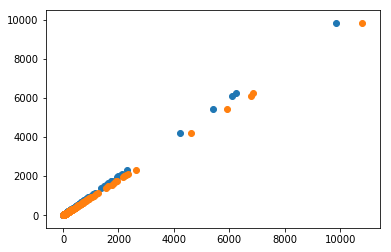

In [12]:
plt.scatter(I_calculated_TMB1, liu_calculated_TMB)
## same value

plt.scatter(I_calculated_TMB2, liu_calculated_TMB)
## same value

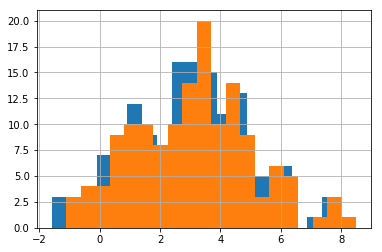

In [13]:
tmb1 = np.log2(I_calculated_TMB1/30)
tmb2 = np.log2(I_calculated_TMB2/30)

tmb1.hist(bins=20)
tmb2.hist(bins=20)

In [14]:
# plot roc-based on the TMB:
#label

In [15]:
patient.BR.value_counts().sum()

144

In [16]:
tmb = tmb1.to_frame('tmb.dan').join(tmb2.to_frame(name = 'tmb.wang'))

# get RNA-seq

#### while correlations involving transcriptomic features had n = 121 tumor samples with data available.

In [18]:
tpm = pd.read_csv('./raw/Supplementary Data 2.txt', sep = '\t', index_col=0)

In [20]:
tpm.shape

(121, 20848)

In [29]:
df = pd.DataFrame(index = tpm.index).join(label).join(tmb)

In [31]:
df['label.liu'].value_counts()

nonresponder    56
responder       47
Name: label.liu, dtype: int64

In [32]:
df['label.kong'].value_counts()

nonresponder    72
responder       47
Name: label.kong, dtype: int64

In [94]:
df = df.join(tpm)

In [97]:
df.sort_index().to_csv('./processed/data.csv')